# <center> Исследование данных Samsung. Кластеризация физической активности пользователей

<center> <img src=https://lms-cdn.skillfactory.ru/assets/courseware/v1/e331f114a292789870501bc8cecd1399/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md11_4_1.jpg align="right" width="300"/> </center>

В этой работе мы попрактикуемся в решении задач кластеризации и используем полученные знания, чтобы оценить результаты.

Мы будем использовать данные, взятые с датчиков акселерометров и гироскопов смартфонов Samsung Galaxy S3. Телефоны носили в кармане добровольцы в возрасте от 19 до 49 лет. Смартфоны постоянно фиксировали значения ускорения и скорости по трём измерениям, а поведение людей записывали на видео, чтобы вручную отметить, какую физическую активность осуществлял человек в тот или иной момент.

Данные содержат следующие признаки:
* различные показатели с акселерометра и гироскопа;
* метка активности (физическая активность человека в конкретный момент).

Попробуем на основе данных с гироскопа и акселерометра разделить активности людей на некоторые схожие по своим характеристикам группы. В идеале наблюдения во время ходьбы должны попасть в один кластер, наблюдения во время подъёма по лестнице — в другой и т. д.

In [23]:
# Импорт библиотек
import pandas as pd # для работы с таблицами
import numpy as np # для работы с числами
from sklearn.preprocessing import StandardScaler # стандартизация данных
from sklearn.decomposition import PCA # для понижения размерности
from sklearn.cluster import KMeans # кластеризация по к-средних
from sklearn.cluster import AgglomerativeClustering # аггломеративная кластеризация
from scipy.cluster.hierarchy import dendrogram, linkage # для отрисовки дерева
from sklearn.cluster import DBSCAN # пространственная кластеризация 
from sklearn.mixture import GaussianMixture # гауссова смесь
# Метрики
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score
# Для графики и отображения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')
# Подавление варнов
import warnings
warnings.filterwarnings('ignore')

## Загрузка и обработка данных

Так как изначально данные были представлены для решения задачи классификации, то они находятся в разных файлах (обучающая и тестовая выборки в соотношении 70/30). Соединим признаки так, чтобы сначала шла обучающая выборка, а затем — тестовая, и отдельно соединим значения целевых переменных.

In [2]:
X_train = np.loadtxt("data/train.txt")
y_train = np.loadtxt("data/train_labels.txt")
 
X_test = np.loadtxt("data/test.txt")
y_test = np.loadtxt("data/test_labels.txt")

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

print(f'Число наблюдений: {X.shape[0]}\n', f'Число фич: {X.shape[1]}', sep='')

Число наблюдений: 10299
Число фич: 561


Найдем также число различных активностей — на сколько кластеров в идеале должны разделиться наблюдения.

In [3]:
print(
    'Список лейблов целевой переменной: ',
    list(map(int, list(np.unique(y, return_counts=True)[0])))
)
print(
    'Список размеров истинных кластеров:',
    list(np.unique(y, return_counts=True)[1])
)

Список лейблов целевой переменной:  [1, 2, 3, 4, 5, 6]
Список размеров истинных кластеров: [1722, 1544, 1406, 1777, 1906, 1944]


Как видим, есть ряд активностей, обозначенных цифрами. Эти метки означают следующее:

- 1 — ходьба;
- 2 — подъём;
- 3 — спуск;
- 4 — сидение;
- 5 — стояние;
- 6 — лежание.

Далее необходимо отмасштабировать признаки. Будем использовать для этого алгоритм StandardScaler.

In [4]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

Исследуем корреляцию, рассчитаем ранг и определитель матрицы. 

In [5]:
# Матрица корреляций
X_corr = np.corrcoef(X_norm.T)
# Параметры матрицы
print('Число столбцов:', X_corr.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(X_corr))
print('Определитель:  ', np.linalg.det(X_corr))

Число столбцов: 561
Ранг матрицы:   470
Определитель:   0.0


Понизим размерность данных с помощью метода главных компонент.

In [6]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99 % разброса данных
pca = PCA(n_components=0.99)
# Обучаем алгоритм на наших данных
X_pca = pca.fit_transform(X)
print(f'Число компонент: {len(X_pca[0])}')
# Матрица корреляций
corr_X_pca = np.corrcoef(X_pca.T)
# Параметры матрицы
print('Число столбцов:', corr_X_pca.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_X_pca))
print('Определитель:  ', np.linalg.det(corr_X_pca))

Число компонент: 157
Число столбцов: 157
Ранг матрицы:   157
Определитель:   0.999999999999993


## Кластеризация

### KMeans

Для начала определим оптимальное количество кластеров, используя внутренние меры кластеризации. Воспользуемся для этого расчетом коэффициента силуэта, индекса Калински — Харабаса и индекса Дэвиса — Болдина.

Выведем оптимальное количество кластеров для каждой метрики, перебирая значения от 2 до 9 включительно.

#### Расчет внутренних мер

In [7]:
silhouette, calinski_harabasz, davies_bouldin = dict(), dict(), dict()
# проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(2,10):
	# обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters=i, n_init=10, random_state=42).fit(X_pca)
	#п редсказываем метки
    y_pred = km.labels_
	# выводим результат для коэффициента силуэта
    silhouette[i] = silhouette_score(X_pca, y_pred)
    calinski_harabasz[i] = calinski_harabasz_score(X_pca, y_pred)
    davies_bouldin[i] = davies_bouldin_score(X_pca, y_pred)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 2, 0.49
Число кластеров с оптимальным индексом Калински-Харабаса: 2, 13909.17
Число кластеров с оптимальным индексом Дэвиса-Болдина: 2, 0.83


Может показаться удивительным, что все три меры единодушно выдали такое расхождение с реальным разделением на кластеры. Однако это совершенно не значит, что они сошлись на неверном значении или что алгоритмы кластеризации работают некорректно. Возможно, такое разделение на другое количество кластеров можно объяснить — позднее мы еще к этому вернемся.

#### Расчет внешних мер

Теперь оценим качество кластеризации с точки зрения внешних мер. Реализуем кластеризацию с помощью классической версии алгоритма k-means. Пусть количество кластеров будет соответствовать реальному числу детектируемых типов активности.

In [8]:
# Определяем модель k-means
model= KMeans(
    n_clusters=6,
    init='random',
    n_init=10,
    random_state=42
)
# Обучаем модель
model.fit(X_pca)
# Выводим метрики
print(f'Значение однородности: {round(homogeneity_score(y, model.labels_), 2)}')
print(f'Значение полноты: {round(completeness_score(y, model.labels_), 2)}')
print(f'Значение скорректированного индекса Рэнда: {round(adjusted_rand_score(y, model.labels_), 2)}')

Значение однородности: 0.58
Значение полноты: 0.6
Значение скорректированного индекса Рэнда: 0.46


#### Классификация активности

Выясним, к каким кластерам были преимущественно отнесены различные активности (т. е. в какой кластер попало большинство наблюдений с этой активностью).

In [9]:
# создаём таблицу сопряжённости
ct = pd.crosstab(y, model.labels_)
# определяем название активностей
ct.index = ['ходьба', 'подъём', 
            'спуск', 'сидение',
            'стояние', 'лежание'
]
ct.columns = list(range(1,7))
ct

,1,2,3,4,5,6
ходьба,872,694,0,0,156,0
подъём,299,1163,0,0,82,0
спуск,757,186,0,0,463,0
сидение,0,3,467,49,0,1258
стояние,0,0,666,0,0,1240
лежание,0,12,171,1761,0,0


Теперь попробуем реализовать алгоритм k-means для двух кластеров (для того числа активностей, которое является оптимальным с точки зрения внутренних мер) и снова посмотрим, как алгоритм разобьёт активности по кластерам.

In [10]:
# Определяем модель k-means
km = KMeans(
    n_clusters=2,
    init='random',
    n_init=10,
    random_state=42
)
# Обучаем модель
km.fit(X_pca)

ctable = pd.crosstab(y, km.labels_)
ctable.index = ['ходьба', 'подъём', 
                'спуск', 'сидение', 
                'стояние', 'лежание'
]
ctable.columns = list(range(1,3))
ctable

,1,2
ходьба,1722,0
подъём,1544,0
спуск,1406,0
сидение,3,1774
стояние,0,1906
лежание,12,1932


Теперь мы видим, что разбиение на два кластера, которое нам навязчиво предлагали внутренние меры, вполне разумно, так как отражает два принципиально разных класса активностей: неподвижные и подвижные.

Об этом же должно свидетельствовать высокое значение полноты получившегося разбиения:

In [11]:
print(f'Значение полноты: {round(completeness_score(y, km.labels_), 2)}')

Значение полноты: 0.99


### AgglomerativeClustering

Сравним полученный результат с агломеративной иерархической кластеризацией. Реализуем её также для двух и шести кластеров и вычислим значение полноты.

In [12]:
ag_n6 = AgglomerativeClustering(n_clusters=6).fit(X_pca)
print("Completeness for 6 clusters: %0.2f" % completeness_score(y, ag_n6.labels_))
ag_n2 = AgglomerativeClustering(n_clusters=2).fit(X_pca)
print("Completeness for 2 clusters: %0.2f" % completeness_score(y, ag_n2.labels_))

Completeness for 6 clusters: 0.68
Completeness for 2 clusters: 1.00


Посмотрим на визуализацию аггломеративной кластеризации.

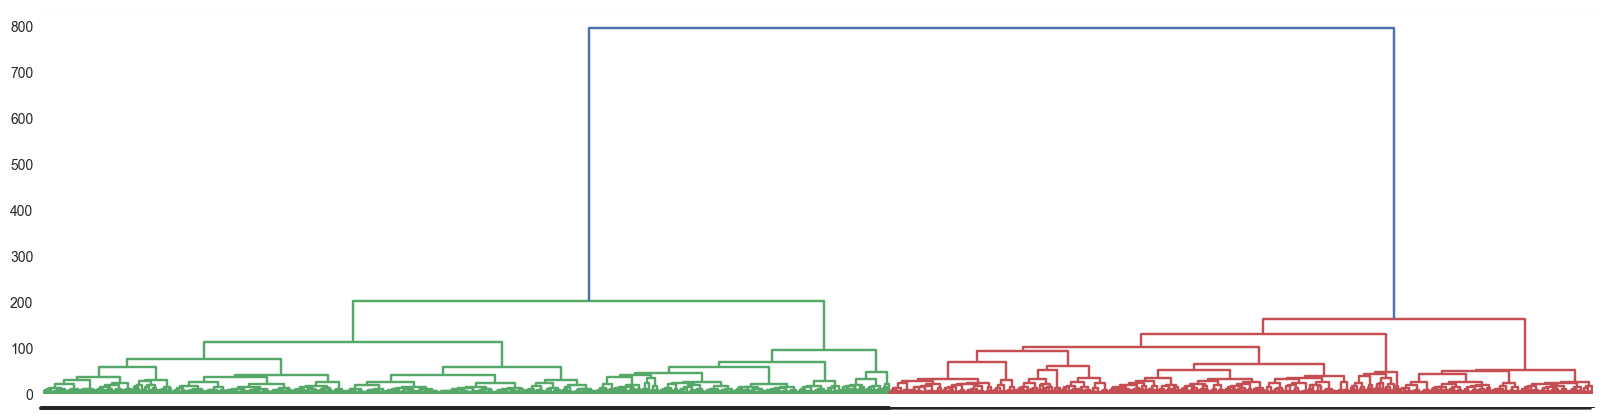

In [13]:
# расссчитаем расстояния между кластерами
linked = linkage(X_pca, 'ward')

plt.figure(figsize=(20, 5))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между друг другом
dendrogram(Z=linked,
            orientation='top',
            labels=ag_n2.labels_,
            distance_sort='descending'
)

plt.show()

Модель придает довольно большое значение различию между активными и пассивными в целом типами состояний пользователей.

### DBSCAN

Попробуем применить DBSCAN. Для начала реализуем его с параметрами по умолчанию.

In [14]:
db_dflt = DBSCAN()
db_dflt.fit(X_pca)
klss, cmpss = np.unique(db_dflt.labels_, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

Кластеры: [-1]
Составы:  [10299]


Алгоритм на дефолтных настройках воспринял весь датасет как шум. Попробуем его немного оптимизировать.

In [15]:
params_db = []
# Проходимся циклом
for eps in np.arange(0.6, 3, 0.2):
    for min_sample in range(2, 20, 2):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(X_pca)
        if len(np.unique(dbscan.labels_)) > 1:
            sil_score = silhouette_score(X_pca, dbscan.labels_, metric='euclidean')
            c_h_score = calinski_harabasz_score(X_pca, dbscan.labels_)
            d_b_score = davies_bouldin_score(X_pca, dbscan.labels_)
            params_db.append(
                (eps, min_sample, sil_score, c_h_score, d_b_score, len(set(dbscan.labels_)))
            )

n_kl_silh = sorted(params_db, key=lambda x: x[2], reverse=True)[0]
print('Параметры, удовлетворяющие оптимальному коэффициенту силуэта:')
print(f'eps: {n_kl_silh[0]}; min_samples: {n_kl_silh[1]}; number_of_clusters: {n_kl_silh[-1]}\n')
n_kl_ch = sorted(params_db, key=lambda x: x[3], reverse=True)[0]
print('Параметры, удовлетворяющие оптимальному индексу Калински-Харабаса:')
print(f'eps: {n_kl_ch[0]}; min_samples: {n_kl_ch[1]}; number_of_clusters: {n_kl_ch[-1]}\n')
n_kl_db = sorted(params_db, key=lambda x: x[4])[0]
print('Параметры, удовлетворяющие оптимальному индексу Дэвиса-Болдина:')
print(f'eps: {n_kl_db[0]}; min_samples: {n_kl_db[1]}; number_of_clusters: {n_kl_db[-1]}\n')

Параметры, удовлетворяющие оптимальному коэффициенту силуэта:
eps: 2.400000000000001; min_samples: 12; number_of_clusters: 2

Параметры, удовлетворяющие оптимальному индексу Калински-Харабаса:
eps: 2.8000000000000007; min_samples: 12; number_of_clusters: 14

Параметры, удовлетворяющие оптимальному индексу Дэвиса-Болдина:
eps: 1.4000000000000004; min_samples: 2; number_of_clusters: 3



In [16]:
eps = [2.4, 2.8, 1.4]
min_samples = [12, 12, 2]

for i in range(3):
    dbscan = DBSCAN(
        eps=eps[i],
        min_samples=min_samples[i]
    )
    # Обучение
    preds_dbscan = dbscan.fit_predict(X_pca)
    klss, cmpss = np.unique(preds_dbscan, return_counts=True)
    print(f'Кластеры: {list(klss)}')
    print(f'Составы:  {list(cmpss)}')
    print('-'*72)

Кластеры: [-1, 0]
Составы:  [10279, 20]
------------------------------------------------------------------------
Кластеры: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Составы:  [8674, 1156, 158, 120, 21, 12, 16, 12, 36, 12, 32, 17, 17, 16]
------------------------------------------------------------------------
Кластеры: [-1, 0, 1]
Составы:  [10295, 2, 2]
------------------------------------------------------------------------


Оптимизация не удалась. Алгоритм по-прежнему видит преимущественно шум.

### GaussianMixture

#### Расчет внутренних мер

In [17]:
silhouette_gm, calinski_harabasz_gm, davies_bouldin_gm = dict(), dict(), dict()
# Проходимся циклом по всем нужным нам значениям количества кластеров
for i in range(2, 10):
	# Обучаем модель GaussianMixture с текущим количеством кластеров
    gm_model = GaussianMixture(n_components=i, random_state=42)
	# Предсказываем метки
    predictions = gm_model.fit_predict(X_pca)
	# Выводим результат для коэффициента силуэта
    silhouette_gm[i] = silhouette_score(X_pca, predictions, metric='euclidean')
    calinski_harabasz_gm[i] = calinski_harabasz_score(X_pca, predictions)
    davies_bouldin_gm[i] = davies_bouldin_score(X_pca, predictions)

n_kl_silh = sorted(silhouette, key=lambda x: silhouette_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным коэффициентом силуэта: {n_kl_silh}, {round(silhouette_gm[n_kl_silh], 2)}')
n_kl_ch = sorted(calinski_harabasz, key=lambda x: calinski_harabasz_gm[x], reverse=True)[0]
print(f'Число кластеров с оптимальным индексом Калински-Харабаса: {n_kl_ch}, {round(calinski_harabasz_gm[n_kl_ch], 2)}')
n_kl_db = sorted(davies_bouldin, key=lambda x: davies_bouldin_gm[x])[0]
print(f'Число кластеров с оптимальным индексом Дэвиса-Болдина: {n_kl_db}, {round(davies_bouldin_gm[n_kl_db], 2)}')

Число кластеров с оптимальным коэффициентом силуэта: 2, 0.45
Число кластеров с оптимальным индексом Калински-Харабаса: 2, 11637.65
Число кластеров с оптимальным индексом Дэвиса-Болдина: 2, 0.89


Модель на алгоритме гауссовой смеси, как и модель на алгоритме k-средних, демонстрирует лучшие значения внутренних мер при числе кластеров 2.

In [18]:
# Инициализируем объект
gm_model = GaussianMixture(
    n_components=2,
    random_state=42
)
# Обучение
preds_gm2 = gm_model.fit_predict(X_pca)
klss, cmpss = np.unique(preds_gm2, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

Кластеры: [0, 1]
Составы:  [5166, 5133]


#### Расчет внешних мер

In [19]:
# Выводим метрики
print(f'Значение однородности: {round(homogeneity_score(y, preds_gm2), 2)}')
print(f'Значение полноты: {round(completeness_score(y, preds_gm2), 2)}')
print(f'Значение скорректированного индекса Рэнда: {round(adjusted_rand_score(y, preds_gm2), 2)}')

Значение однородности: 0.3
Значение полноты: 0.78
Значение скорректированного индекса Рэнда: 0.28


#### Классификация активности

In [20]:
ctable_gm2 = pd.crosstab(y, preds_gm2)
ctable_gm2.index = ['ходьба', 'подъём', 
                'спуск', 'сидение', 
                'стояние', 'лежание'
]
ctable_gm2.columns = list(range(1,3))
ctable_gm2

,1,2
ходьба,0,1722
подъём,0,1544
спуск,0,1406
сидение,1636,141
стояние,1750,156
лежание,1780,164


In [21]:
# Инициализируем объект
gm_model = GaussianMixture(
    n_components=6,
    random_state=42
)
# Обучение
preds_gm6 = gm_model.fit_predict(X_pca)
klss, cmpss = np.unique(preds_gm6, return_counts=True)
print(f'Кластеры: {list(klss)}')
print(f'Составы:  {list(cmpss)}')

# создаём таблицу сопряжённости
ctable_gm6 = pd.crosstab(y, preds_gm6)
# определяем название активностей
ctable_gm6.index = ['ходьба', 'подъём', 
            'спуск', 'сидение',
            'стояние', 'лежание'
]
ctable_gm6.columns = list(range(1,7))
ctable_gm6

Кластеры: [0, 1, 2, 3, 4, 5]
Составы:  [1425, 816, 1930, 1597, 1938, 2593]


,1,2,3,4,5,6
ходьба,0,197,573,0,952,0
подъём,0,146,1219,0,179,0
спуск,0,473,126,0,807,0
сидение,472,0,2,47,0,1256
стояние,569,0,0,0,0,1337
лежание,384,0,10,1550,0,0


In [22]:
# Выводим метрики
print(f'Значение однородности: {round(homogeneity_score(y, preds_gm6), 2)}')
print(f'Значение полноты: {round(completeness_score(y, preds_gm6), 2)}')
print(f'Значение скорректированного индекса Рэнда: {round(adjusted_rand_score(y, preds_gm6), 2)}')

Значение однородности: 0.57
Значение полноты: 0.59
Значение скорректированного индекса Рэнда: 0.45


## Итог

К сожалению, ни одна из созданных нами моделей не способна верно распознавать типы активностей пользователей смартфонов. Однако у нас получились в целом три модели, сносно различающих классы типы активностей, характеризующих движение и пассивное состояние. Лучшей из трех наших моделей является модель, основанная на алгоритме аггломеративной кластеризации.

Наше решение не является идеальным, но и вряд ли исчерпывает возможности алгоритмов кластеризации вообще. Однако, т.к. данные в нашей задаче имеют разметку, эту самую задачу можно попытаться также решить с помощью алгоритмов классификации. Но этим все же мы займемся не здесь.